# Google Play Review Analysis – Exploratory Analysis & Data Quality Assessment

This notebook documents the collection and exploratory analysis of Google Play Store reviews for ChatGPT. Reviews were collected using multiple sorting regimes (“newest” and “most relevant”) to mitigate recency and engagement bias.

The goal of this analysis is to:
- Assess raw data quality and readiness for downstream use
- Understand key distributions, temporal patterns, rating behavior, and text characteristics
- Identify potential biases or quirks in the data


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("chatgpt_google_play_reviews_raw.csv")

df["review_text"] = df["review_text"].fillna("")
df["review_date"] = pd.to_datetime(df["review_date"])

df["month"] = df["review_date"].dt.to_period("M")
df["review_length"] = df["review_text"].str.len()
df["word_count"] = df["review_text"].str.split().str.len()

df.shape


(15873, 12)

## Data Quality Assessment

This section evaluates the quality of the raw review dataset, including completeness, consistency, and potential preprocessing requirements before the data could be used for labeling or modeling.


In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15873 entries, 0 to 15872
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   review_uid     15873 non-null  object        
 1   user_name      15873 non-null  object        
 2   rating         15873 non-null  int64         
 3   review_text    15873 non-null  object        
 4   review_date    15873 non-null  datetime64[ns]
 5   thumbs_up      15873 non-null  int64         
 6   app_version    15392 non-null  object        
 7   sort_mode      15873 non-null  object        
 8   scrape_time    15873 non-null  object        
 9   month          15873 non-null  period[M]     
 10  review_length  15873 non-null  int64         
 11  word_count     15873 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(6), period[M](1)
memory usage: 1.5+ MB


The dataset contains approximately 16k reviews with consistent data types across core fields such as rating, review date, and review text. No obvious structural issues are observed at the schema level.


In [25]:
df.isna().mean().sort_values(ascending=False)


app_version      0.030303
review_uid       0.000000
user_name        0.000000
rating           0.000000
review_text      0.000000
review_date      0.000000
thumbs_up        0.000000
sort_mode        0.000000
scrape_time      0.000000
month            0.000000
review_length    0.000000
word_count       0.000000
dtype: float64

In [26]:
df.duplicated().mean()


np.float64(0.0)

Most core fields (rating, review date, review text) are well-populated. Some metadata fields exhibit partial missingness, which suggests that targeted preprocessing or selective field usage would be required prior to modeling.


## Exploratory Analysis
### Rating Distribution

This section examines how user ratings are distributed across the 1–5 star scale to assess polarization and self-selection in review behavior.


In [27]:
rating_dist = df["rating"].value_counts(normalize=True).sort_index()
rating_dist


rating
1    0.165123
2    0.054684
3    0.078624
4    0.123984
5    0.577585
Name: proportion, dtype: float64

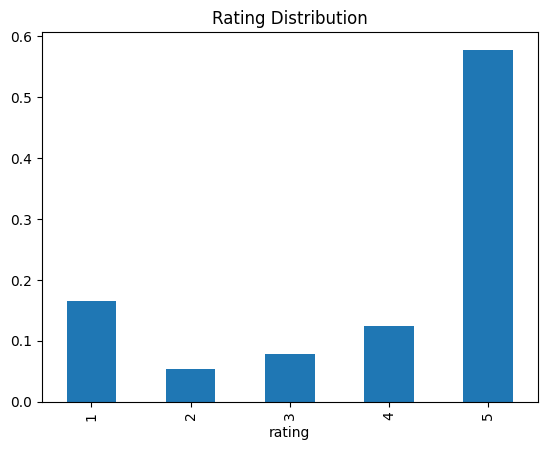

In [28]:
rating_dist.plot(kind="bar")
plt.title("Rating Distribution")
plt.show()


Ratings are highly polarized, with a strong concentration at 5-star ratings and a meaningful share of 1-star reviews. Neutral ratings (2–4 stars) are relatively underrepresented, indicating substantial self-selection in who chooses to leave reviews.


### Temporal Patterns – Review Volume

This section explores how review activity varies over time.


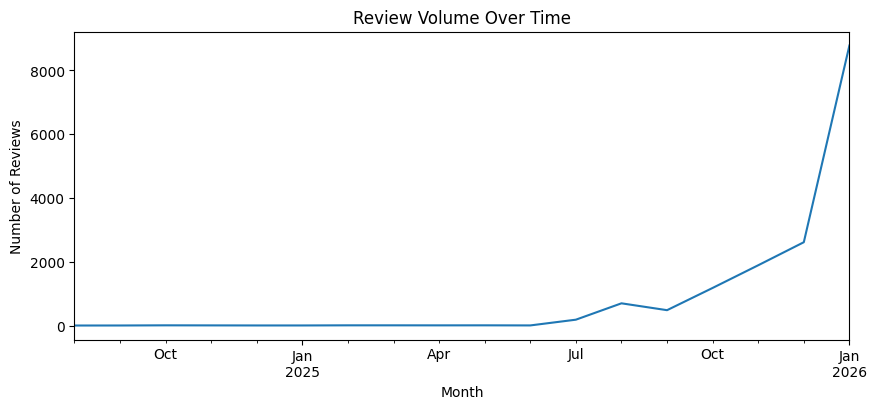

In [29]:
monthly_counts = df.groupby("month").size()

monthly_counts.plot(figsize=(10,4))
plt.title("Review Volume Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()


Review volume exhibits a strong recency skew, with the majority of reviews concentrated in recent months. Earlier periods are sparsely represented, reinforcing the presence of recency bias in the raw data.


### Temporal Patterns – Average Rating


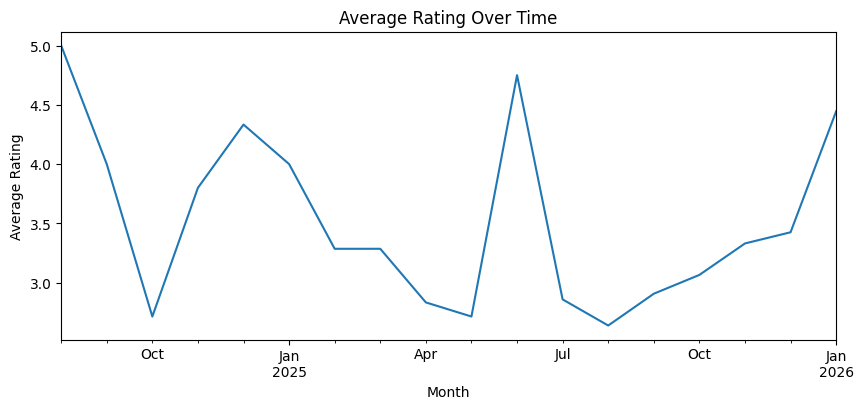

In [30]:
monthly_rating = df.groupby("month")["rating"].mean()

monthly_rating.plot(figsize=(10,4))
plt.title("Average Rating Over Time")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.show()


Average ratings vary meaningfully over time, suggesting that user sentiment is not stationary and may reflect product updates, feature changes, or shifts in user expectations.


### Rating Behavior and Text Characteristics

This section examines how user behavior and review text differ across rating levels.


In [31]:
df.groupby("rating")[["review_length", "word_count"]].mean()


,review_length,word_count
rating,,
1,276.830599,50.393743
2,297.014977,54.642857
3,239.458333,44.157853
4,172.850102,32.255589
5,99.847731,18.557155


Lower-rated reviews tend to be significantly longer and more detailed than higher-rated reviews, suggesting that negative experiences motivate more explanatory feedback, while positive experiences are often expressed more succinctly.


In [32]:
df.groupby("rating")["thumbs_up"].mean()


rating
1    23.494849
2    47.167051
3    34.885417
4    64.981199
5    34.817081
Name: thumbs_up, dtype: float64

Engagement patterns vary by rating, with mid-to-high ratings often receiving the most “helpful” votes. This indicates that relevance ranking is influenced by perceived informativeness, not rating extremity alone.


In [33]:
df["word_count"].describe()


count    15873.000000
mean        29.498645
std         30.348395
min          1.000000
25%          2.000000
50%         20.000000
75%         52.000000
max        112.000000
Name: word_count, dtype: float64

Review text length is highly right-skewed, with many short reviews and a long tail of more detailed feedback. This has implications for downstream text modeling and feature extraction.


In [34]:
df["is_short"] = df["word_count"] < 10
df.groupby("rating")["is_short"].mean()


rating
1    0.128577
2    0.105991
3    0.193109
4    0.349085
5    0.611038
Name: is_short, dtype: float64

Short, low-effort reviews are disproportionately concentrated among 5-star ratings, while lower-rated reviews are more likely to contain substantive textual feedback.


## Biases and Data Quirks


In [35]:
df["rating"].isin([1, 5]).mean()


np.float64(0.7427077427077428)

Approximately three-quarters of reviews fall into extreme rating categories (1 or 5 stars), highlighting strong polarization and selection bias in observed user feedback.


In [36]:
pd.crosstab(
    df["sort_mode"],
    df["rating"],
    normalize="index"
)


rating,1,2,3,4,5
sort_mode,,,,,
most_relevant,0.268894,0.093611,0.119649,0.144418,0.373428
newest,0.063000,0.016375,0.038250,0.103875,0.778500


Sorting mode materially affects the observed rating distribution. “Newest” reviews are heavily skewed positive, while “most relevant” reviews exhibit a more balanced mix, reinforcing the value of collecting across multiple sort orders.
